## **Applying Adorno**

### **Introduction**

Theodor Adorno died in 1969, decades before the first smartphone was manufactured or the first algorithm was coded. Yet, if one reads his critique of the 'Culture Industry' today, it reads less like mid-century philosophy and more like a user manual for the TikTok 'For You' page. 

These algorithmic recommendation engines have become the invisible curators of modern culture. Nowhere is this more visible with the annual arrival of Spotify Wrapped. By taking our raw data it transforms our listening habits into a bright, shareable graphic, assuring us that our taste is uniquely our own. However, through the lens of Theodor Adorno, this customized data is not proof of our individuality; it is the ultimate manifestation of 'pseudo-individuality' a system where the machine sells our own conformity back to us disguised as personal choice.

**Thesis:** Through a qualitative analysis of user comments across 31 top-streamed songs on YouTube, this essay argues that digital engagement has not liberated the listener, but rather standardized their response. The repetitive nature of the comments—focused on identity signaling rather than musical critique—confirms Adorno’s theory of 'regressive listening,' where the audience becomes an echo chamber for the Culture Industry's own marketing.

### **Core Concepts**

**Standardization:**
Adorno argues that popular music is built upon rigid, formulaic structures (e.g., 32-bar chorus, verse-chorus structure) that are, in essence, all the same. This predictability means listeners already know what to expect, and any "new" song is just a variation of a previous one.

**Pseudo-individualization:**
While the songs are standardized, the industry adds a "veneer" of difference—special "effects," unique singer styles, or minor melodic variations—to make the music seem unique or individual. This creates an "illusion of choice" that keeps listeners engaged while consuming the same formulaic product.

**Passive Listening (Regression of Listening):**
Adorno argues that popular music does not require active, intellectual, or critical engagement. Because it is standardized, the music "hears for the listener," offering "pre-digested" content that makes any real effort of listening unnecessary.

**The Culture Industry and Commodification:**
Music is treated as a commodity with exchange value, produced to generate profit within a capitalist framework. The "culture industry" aims to create "false needs" that are satisfied by these standardized products, reinforcing a conformist, complacent, and docile audience.

### **Mechanisms of Control**

**"Plug" and "Pluggers":**
Adorno notes the role of music industry "plugging" (aggressive promotion), where certain songs are repetitively played until they become familiar, creating a "pseudo-hit." This process is aided by music journalists and song-pluggers.

**Mass Catharsis and Social Control:**
Popular music acts as a "catharsis for the masses." It allows listeners to release frustration about their lives, but this release ultimately reconciles them to their social dependence, keeping them "firmly in line" rather than fostering rebellion.

**The "Baby Talk" Effect:**
Adorno describes the lyrics and melodies as "baby talk" that plays on the listener's sense of dependence, similar to how glamour plays on the desire for strength.

### **Comparative Analysis**

**Contrast with "Serious" Music:**
Adorno contrasts popular music with "serious" music (like the classical canon or the avant-garde).

*Serious Music*: "Every detail derives its musical sense from the concrete totality of the piece."

*Popular Music*: Every detail is substitutable.


### Step 1: Data Collection -- Where can we find the data?

Short answer [Top Tracks of 2025 Global on Spotify](https://open.spotify.com/playlist/37i9dQZF1DX18jTM2l2fJY) which contains a list of the top 50 songs with most streams on spotify last year.




In [ ]:
import pandas as pd
import json
import time
from itertools import islice
from youtube_comment_downloader import YoutubeCommentDownloader, SORT_BY_POPULAR

: 

In [ ]:
# Load the CSV
df_youtube_urls = pd.read_csv('find_youtube_urls.csv')

# Config
MAX_COMMENTS = 310000
OUTPUT_FILE = 'youtube_comments_2.json'

downloader = YoutubeCommentDownloader()
all_comments = []

# Calculate how many comments per video (distribute evenly)
urls = df_youtube_urls['YouTube URL'].dropna().tolist()
num_videos = len(urls)
comments_per_video = MAX_COMMENTS // num_videos
print(f"Scraping up to {comments_per_video} comments per video across {num_videos} videos...")
print(f"Target total: {MAX_COMMENTS} comments\n")

for idx, row in df_youtube_urls.iterrows():
    url = row.get('YouTube URL')
    title = row.get('Song Title', 'Unknown')
    artists = row.get('Artists', 'Unknown')

    if pd.isna(url) or not url.strip():
        print(f"  Skipping row {idx} — no URL")
        continue

    print(f"[{idx + 1}/{len(df_youtube_urls)}] {title} — {artists}")
    print(f"  URL: {url}")

    try:
        comments = downloader.get_comments_from_url(url, sort_by=SORT_BY_POPULAR)
        count = 0
        for comment in islice(comments, comments_per_video):
            comment['song_title'] = title
            comment['artists'] = artists
            comment['youtube_url'] = url
            all_comments.append(comment)
            count += 1

        print(f"  ✓ Collected {count} comments")
    except Exception as e:
        print(f"  ✗ Error: {e}")

    # Brief pause to avoid rate limiting
    time.sleep(1)

print(f"\nTotal comments collected: {len(all_comments)}")

# Save to JSON
with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
    json.dump(all_comments, f, ensure_ascii=False, indent=2)

print(f"Saved to {OUTPUT_FILE}")


In [10]:
import json
# Load comments from JSON
with open('youtube_comments.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df_comments = pd.DataFrame(data)

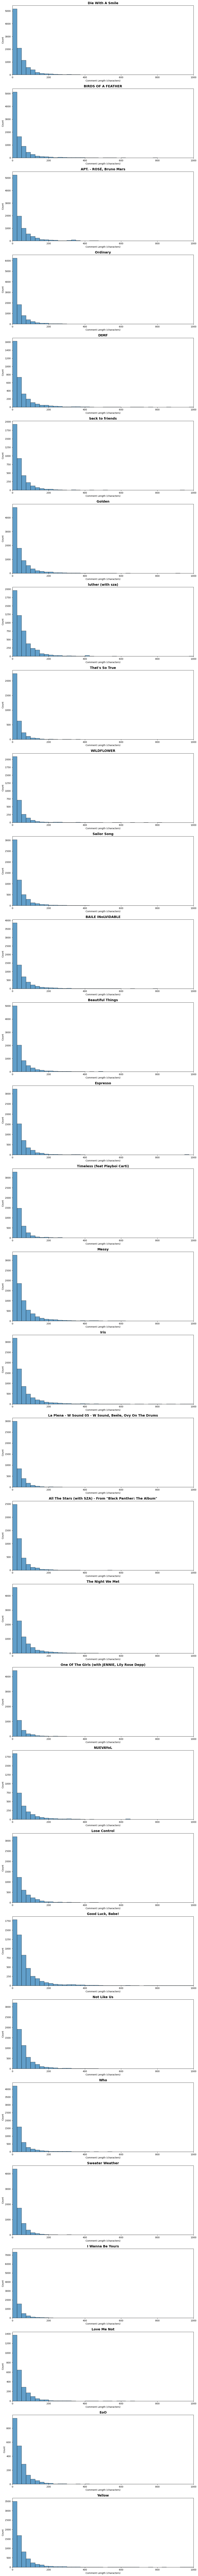

In [12]:
import matplotlib.pyplot as plt
import numpy as np

df_comments['text_length'] = df_comments['text'].astype(str).apply(len)

songs = df_comments['song_title'].unique()
max_len = df_comments['text_length'].max()
bins = np.arange(0, max_len + 25, 25)

fig, axes = plt.subplots(len(songs), 1, figsize=(12, 5 * len(songs)))

for ax, song in zip(axes, songs):
    song_data = df_comments[df_comments['song_title'] == song]['text_length']
    ax.hist(song_data, bins=bins, edgecolor='black', alpha=0.7)
    ax.set_title(f'{song}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Comment Length (characters)')
    ax.set_ylabel('Count')
    ax.set_xlim(0, min(max_len, 1000))

plt.tight_layout()
plt.show()

In [15]:
with open('top_comments_by_song.md', 'w', encoding='utf-8') as f:
    f.write('# Top 25 Longest Comments by Song\n\n')

    for song in df_comments['song_title'].unique():
        song_df = df_comments[df_comments['song_title'] == song].nlargest(25, 'text_length')
        artists = song_df['artists'].iloc[0]

        f.write(f'## 🎵 {song}\n')
        f.write(f'**Artists:** {artists}\n\n')

        for i, (_, row) in enumerate(song_df.iterrows(), 1):
            f.write(f'### {i}. {row["author"]} ({row["text_length"]} chars)\n\n')
            f.write(f'> {row["text"]}\n\n')
            f.write(f'👍 {row["votes"]} · {row["time"]}\n\n')
            f.write('---\n\n')

print('Saved to top_comments_by_song.md')

Saved to top_comments_by_song.md


In [16]:
import pandas as pd
import json

# Convert 'replies' string to numeric — empty strings become 0
df_comments['replies_count'] = pd.to_numeric(
    df_comments['replies'].replace('', '0'), errors='coerce'
).fillna(0).astype(int)

print(f"Total comments loaded: {len(df_comments)}")
print(f"Unique songs: {df_comments['song_title'].nunique()}")
print()

# Generate the markdown report
with open('top_replies_by_song.md', 'w', encoding='utf-8') as f:
    f.write('# Top 25 Most Replied Comments by Song\n\n')

    for song in df_comments['song_title'].unique():
        song_df = df_comments[df_comments['song_title'] == song].nlargest(25, 'replies_count')
        artists = song_df['artists'].iloc[0]

        f.write(f'## 🎵 {song}\n')
        f.write(f'**Artists:** {artists}\n\n')

        for i, (_, row) in enumerate(song_df.iterrows(), 1):
            f.write(f'### {i}. {row["author"]} ({row["replies_count"]} replies)\n\n')
            f.write(f'> {row["text"]}\n\n')
            f.write(f'👍 {row["votes"]} · {row["time"]}\n\n')
            f.write('---\n\n')

print('Saved to top_replies_by_song.md')


Total comments loaded: 202737
Unique songs: 31

Saved to top_replies_by_song.md
